# 10. 无迹卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

在上一章中，我们讨论了非线性系统带来的困难。这种非线性可以出现在两个方面。它可能存在于我们的测量中，比如雷达测量到的物体的斜距。斜距需要通过平方根计算x、y坐标：

$$x=\sqrt{\text{slant}^2 - \text{altitude}^2}$$

非线性也可能出现在过程模型中——比如我们可能在跟踪一颗穿越空气的球，空气阻力会导致非线性行为。标准的卡尔曼滤波器在这些问题上表现不佳，甚至无法正常工作。

在上一章中，我给你展示了类似这样的图表。我稍微改变了方程以突显非线性的影响。

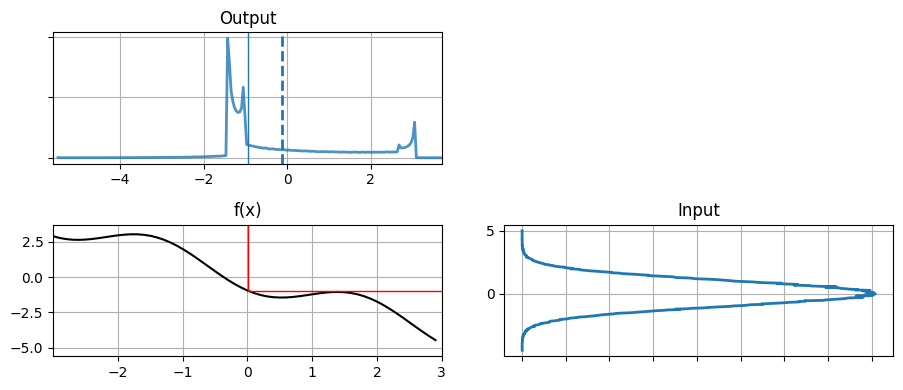

In [3]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np

# create 500,000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

plot_nonlinear_func(data, f)

我是通过从输入中获取 500,000 个样本，将其通过非线性变换，并构建结果的直方图生成这张图的。我们称这些点为“sigma点”。通过输出的直方图，我们可以计算平均值和标准差，这将给我们一个更新后的、虽然是近似的高斯分布。

让我给你展示一下在通过 `f(x)` 变换之前和之后的数据散点图。

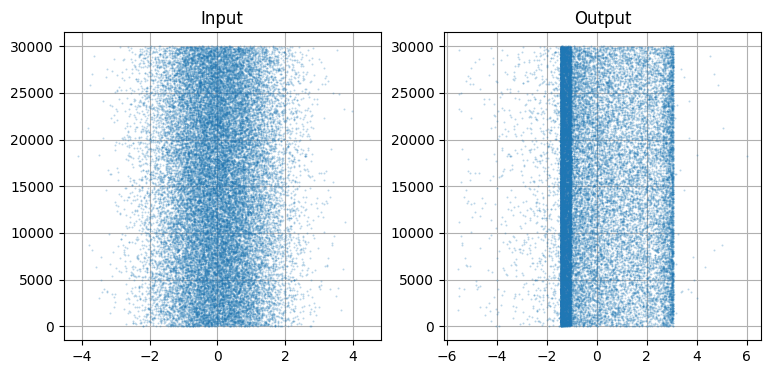

In [4]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1);

数据本身呈现出高斯分布的样子，事实上也是如此。我的意思是它看起来像是围绕零均值散布的白噪声。相比之下，`g(data)` 具有明确定义的结构。有两个带状区域，中间有大量的点。在带状区域的外侧有分散的点，但在负数方向有更多的点。

也许你已经想到了，这种采样过程构成了我们问题的解决方案。假设对于每次更新，我们生成了 500,000 个点，经过函数处理，然后计算了结果的均值和方差。这被称为“蒙特卡罗”方法，某些卡尔曼滤波设计中采用了这种方法，比如集合滤波器和粒子滤波器。采样不需要专业知识，也不需要一个封闭的解。只要我们以足够的sigma点进行采样，无论函数多么非线性或行为多么糟糕，我们都能建立一个准确的输出分布。

“足够多的点”是个问题。上面的图是由 500,000 个 sigma 点创建的，但输出仍然不够平滑。更糟糕的是，这仅针对一个维度。所需的点数按维数的幂级数增加。如果对于 1 维度只需要 500 点，那么对于两个维度，就需要 500 的平方，即 250,000 点；对于三个维度，就需要 500 的立方，即 125,000,000 点，依此类推。因此，虽然这种方法确实可行，但计算代价非常高。集合滤波器和粒子滤波器使用巧妙的技术显著降低了这种维度，但计算负担仍然非常大。无迹卡尔曼滤波器使用 sigma 点，但通过使用确定性方法选择这些点来大幅减少计算量。

# sigma点 - 从分布中取样

让我们用一个二维协方差椭圆来看这个问题。我之所以选择二维，只是因为容易绘制；这个概念可以扩展到任意维度。假设有一个任意的非线性函数，我们将从第一个协方差椭圆中取出随机点，通过这个非线性函数进行变换，然后绘制它们的新位置。接着，我们可以计算变换后点的均值和协方差，将其作为我们对均值和概率分布的估计。

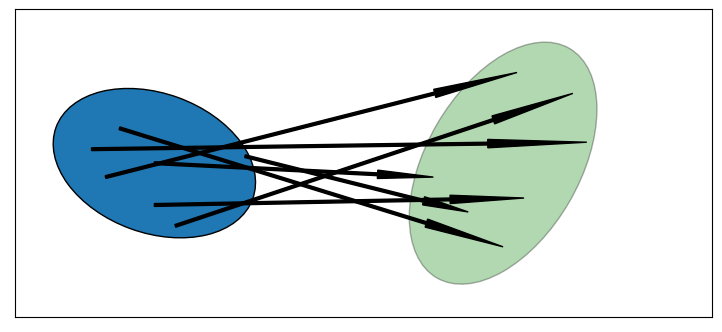

In [5]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

左侧显示了一个椭圆，表示两个状态变量的$1\sigma$分布。箭头显示了一些随机抽样点可能会被某个任意非线性函数转换为一个新的分布。右侧的椭圆是半透明的，表示它是这些点集的*估计*均值和方差。

让我们编写一个函数，将从以下高斯分布中随机抽取的10,000个点经过非线性系统处理：

$$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

通过非线性系统：

$$\begin{cases}\begin{aligned}\bar x&=x+y\\
\bar y&= 0.1x^2 + y^2\end{aligned} \end{cases}$$

Difference in mean x=0.145, y=42.179


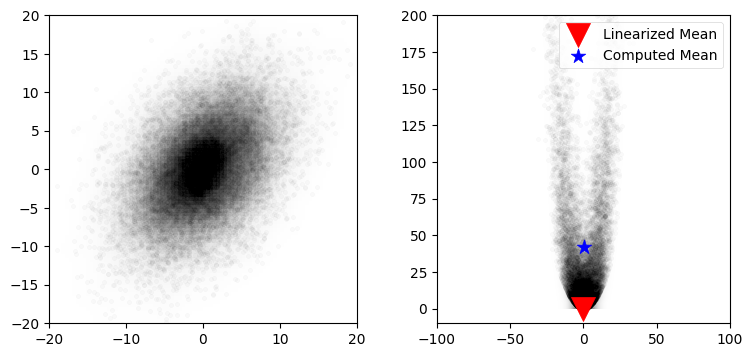

In [6]:
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean');

这个图展示了这个函数的强非线性特性，以及如果按照扩展卡尔曼滤波器的方式进行线性化，会导致的大误差。我们将在下一章学习这个内容。

# 一个快速的例子

我很快就会开始介绍无迹卡尔曼滤波器（UKF）用来选择sigma点并进行计算的数学方法。但我们先从一个例子开始，这样你就可以看到目标，可以说是这个方法的目的。

我们将学习到，UKF可以使用许多不同的算法来生成sigma点。FilterPy提供了几种算法。这是其中的一个可能性：

In [7]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

稍后会更清楚，但是对于任何给定的均值和协方差，该对象将生成加权的sigma点。让我们看一个例子，其中点的大小表示它们被赋予的权重：

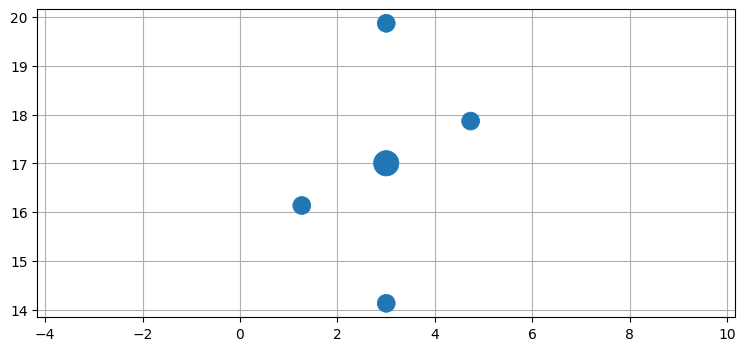

In [8]:
from kf_book.ukf_internal import plot_sigmas
plot_sigmas(sigmas, x=[3, 17], cov=[[1, .5], [.5, 3]])

你可以看到，我们有5个围绕着均值（3，17）的点，呈奇怪的模式分布。可能会觉得这些点会比50万个随机生成的点效果更好，但实际上会的！

好的，现在让我们实现这个滤波器。我们将实现一个标准的1D线性滤波器；我们还没有准备好去处理非线性滤波器。滤波器的设计与我们到目前为止学到的并没有太大区别，只有一个不同点。KalmanFilter类使用矩阵 $\mathbf F$ 来计算状态转移函数。矩阵意味着**线性**代数，适用于线性问题，但不适用于非线性问题。因此，我们不再提供矩阵，而是提供一个函数，就像我们上面所做的那样。KalmanFilter类使用另一个矩阵 $\mathbf H$ 来实现测量函数，将状态转换为相应的测量。同样，矩阵暗示着线性性质，所以我们提供一个函数。或许现在 $\mathbf H$ 为何被称为“测量函数”就清楚了；对于线性卡尔曼滤波器，它是一个矩阵，但那只是一种快速计算一个恰好是线性的函数的方法。

不再多说了，以下是用于1D跟踪问题的状态转移函数和测量函数，其中状态为 $\mathbf x = [x \, \, \dot x]^ \mathsf T$：

In [9]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

明确一点，这是一个线性示例。对于线性问题，不需要使用UKF，但我从最简单的例子开始。但请注意，我编写了 `fx()` 来计算 $\mathbf{\bar x}$，用的是一组方程而不是矩阵乘法。这是为了说明我可以在这里实现任意的非线性函数；我们不局限于线性方程。

其余设计与之前一样。设计 $\mathbf P$、$\mathbf R$ 和 $\mathbf Q$。你知道怎么做，让我们完成滤波器并运行它。

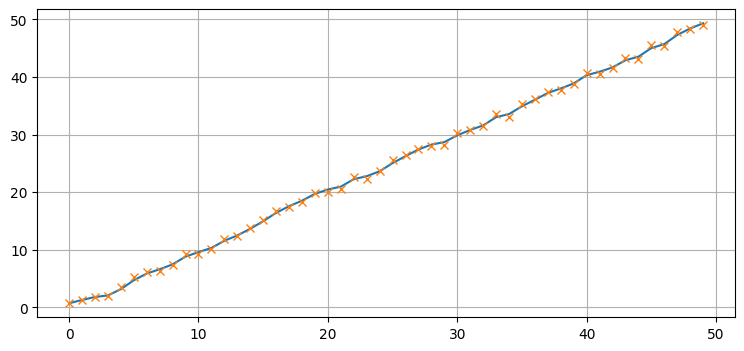

In [10]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs);
plt.plot(zs, marker='x', ls='');

这里其实没有太多新内容。你需要创建一个对象来为你生成西格玛点，并提供函数而不是矩阵给 $\mathbf F$ 和 $\mathbf H$，但其余部分与之前的相同。这应该足够让你对数学和算法有足够的信心，从而理解无迹卡尔曼滤波器在做什么。

# 选择sigma点

在章节开始的时候，我使用了 500,000 个随机生成的西格玛点来计算通过非线性函数传递的高斯分布的概率分布。虽然计算出的均值相当准确，但每次更新计算 500,000 个点会使我们的滤波器变得极其缓慢。那么，我们可以使用的最少采样点是多少？这种问题的表述对点的种类有什么样的限制？我们假设我们对非线性函数没有特殊的了解，因为我们想找到一个适用于任何函数的通用算法。

让我们考虑最简单的情况，看看它是否能提供一些见解。最简单的系统是**恒等函数**：$f(x) = x$。如果我们的算法对恒等函数不起作用，那么滤波器就无法收敛。换句话说，如果输入是 1（对于一维系统），输出也必须是 1。如果输出不同，比如 1.1，那么当我们在下一个时间步骤将 1.1 输入到变换中时，我们会得到另一个数字，也许是 1.23。这个滤波器会发散。

我们可以使用的最少点数是每个维度一个点。这就是线性卡尔曼滤波器使用的数量。对于分布 $\mathcal{N}(\mu,\sigma^2)$ 的卡尔曼滤波器的输入就是 $\mu$ 本身。所以虽然这对于线性情况有效，但对于非线性情况来说并不是一个好答案。

也许我们可以每个维度使用一个点，但以某种方式进行修改。然而，如果我们传递某个值 $\mu+\Delta$ 到恒等函数 $f(x)=x$ 中，它不会收敛，所以这不会起作用。如果我们不改变 $\mu$，那么这将成为标准的卡尔曼滤波器。我们必须得出结论，一个样本不起作用。

接下来我们能选择的最低数量是两个。考虑高斯分布是对称的这一事实，我们可能总是希望我们的采样点之一是输入的均值，这样恒等函数才能起作用。两个点需要我们选择均值，然后再选一个点。那一个点会在我们的输入中引入一个不对称，这可能并不是我们想要的。要让这个工作于恒等函数 $f(x)=x$ 将会非常困难。

接下来最低的数量是 3 个点。3 个点允许我们选择均值，然后选择均值两边的一个点，就像下面的图表所示。

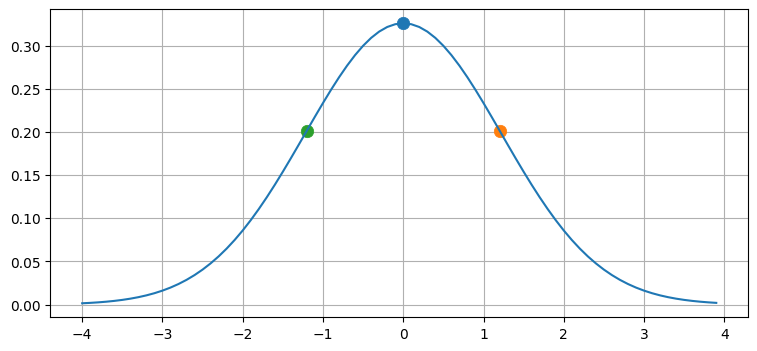

In [11]:
ukf_internal.show_3_sigma_points()

我们可以将这些点通过非线性函数 $f(x)$ 并计算结果的均值和方差。均值可以计算为这 3 个点的平均值，但这并不是非常通用的。例如，对于一个非常非线性的问题，我们可能希望比起外部点，更高地赋予中心点更高的权重，或者我们可能希望给外部点更高的权重。

一个更通用的方法是计算加权平均值 $\mu = \sum_i w_i\, f(\mathcal{X}_i)$，其中用花体 $\mathcal{X}$ 表示西格玛点。我们需要权重的总和等于一。在满足这个要求的情况下，我们的任务是选择 $\mathcal{X}$ 及其相应的权重，使它们计算出变换后的西格玛点的均值和方差。

如果我们给均值加权，给协方差加权也是有道理的。可以对均值（$w^m$）和协方差（$w^c$）使用不同的权重。我使用上标来在以下方程中给索引留出空间。我们可以写成：

$$\begin{aligned}
\mathbf{约束条件:}\\
1 &= \sum_i{w_i^m} \\
1 &= \sum_i{w_i^c} \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

前两个方程是权重必须总和为一的约束条件。第三个方程是计算加权均值的方法。第四个方程可能不太熟悉，但回想一下两个随机变量的协方差的方程是：

$$COV(x,y) = \frac{\sum(x-\bar x)(y-\bar{y})}{n}$$

这些约束条件并不构成唯一的解。例如，如果你使 $w^m_0$ 更小，你可以通过使 $w^m_1$ 和 $w^m_2$ 更大来补偿。你可以为均值和协方差使用不同的权重，也可以使用相同的权重。实际上，这些方程并不要求任何点都是输入均值，尽管这样做似乎是“好的”。

我们希望有一个算法满足这些约束条件，最好是每个维度只有 3 个点。在继续之前，我想确保这个想法是清楚的。以下是同一个协方差椭圆的三个不同西格玛点的示例，它们具有不同的权重给予每个点的大小成比例。

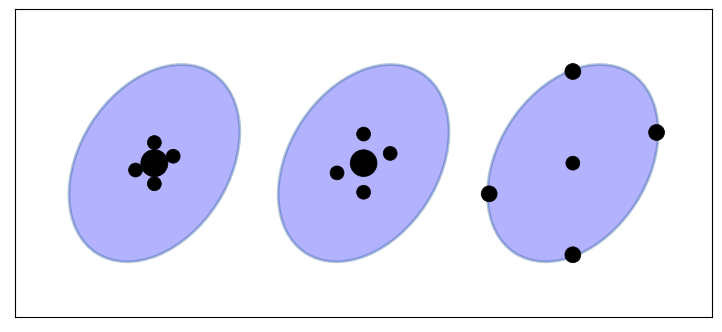

In [12]:
ukf_internal.show_sigma_selections()

这些点并不沿着椭圆的长短轴排列；约束条件并没有要求我这样做。我展示的是均匀间隔的点，但约束条件并没有要求这样做。

西格玛点的排列和加权会影响我们对分布进行采样的方式。距离很近的点会采样局部效应，因此对于非常非线性的问题可能效果更好。相距较远或偏离椭圆轴线的点会采样非局部效应和非高斯行为。然而，通过改变每个点使用的权重，我们可以缓解这种情况。如果点远离均值但权重很小，我们将纳入有关分布的一些知识，而不允许问题的非线性性产生错误的估计。

请理解，选择西格玛点的方法有无穷无尽的可能性。我选择的约束条件只是其中一种方法。例如，并非所有创建西格玛点的算法都要求权重总和为一。事实上，我在这本书中偏爱的算法就没有这个特性。

# 无迹变换

暂且假设存在一种选择西格玛点和权重的算法。那么，西格玛点是如何用于实现滤波器的呢？

*无迹变换*是算法的核心，然而它非常简单。它将西格玛点 $\boldsymbol{\chi}$ 通过一个非线性函数得到一组转换后的点。

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

然后计算转换后点集的均值和协方差。这个均值和协方差成为新的估计值。下图展示了无迹变换的操作。右侧的绿色椭圆代表了对转换后西格玛点计算得到的均值和协方差。

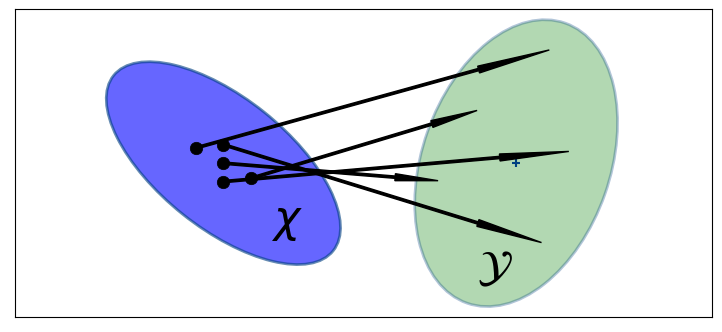

In [13]:
ukf_internal.show_sigma_transform(with_text=True)

西格玛点的均值和协方差计算如下：

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

这些方程应该很熟悉——它们就是我们上面推导出的约束方程。

简而言之，无迹变换获取来自任意概率分布的采样点，通过任意非线性函数处理这些点，并为每个变换后的点产生一个高斯分布。希望你能想象我们如何利用这一点来实现非线性卡尔曼滤波器。一旦我们得到了高斯分布，我们已经开发的所有数学工具都可以派上用场！

“无迹”这个名字可能有点令人困惑。其实并没有什么实际含义。这是发明者开玩笑说他的算法没有“气味”，结果这个名字就被采用了。这个术语在数学上并没有特定的含义。

# 无迹变换的准确性

之前我们编写了一个函数，通过将 50,000 个点通过一个非线性函数，找到了分布的均值。现在让我们通过相同的函数将 5 个西格玛点传递，然后使用无迹变换计算它们的均值。我们将使用 FilterPy 中的 *MerweScaledSigmaPoints()* 函数创建西格玛点，并使用 `unscented_transform` 执行变换；我们稍后会学习这些函数。在本章的第一个例子中，我使用了 `JulierSigmaPoints`；它们都选择西格玛点，但方式不同，我会稍后解释。

Difference in mean x=-0.097, y=0.549


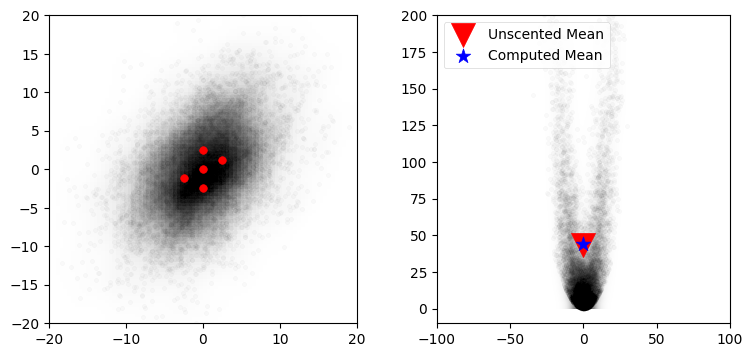

In [14]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

#generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30);

我觉得这个结果非常了不起。仅使用 5 个点，我们就能以惊人的准确度计算出均值。在 x 方向的误差仅为 -0.097，而在 y 方向的误差为 0.549。相比之下，线性化方法（由即将在下一章学习的扩展卡尔曼滤波器（EKF）使用）在 y 方向的误差超过了 43。如果你看一下生成西格玛点的代码，你会发现它对非线性函数一无所知，只知道我们初始分布的均值和协方差。即使我们有完全不同的非线性函数，也会生成相同的 5 个西格玛点。

我承认我选择了一个使得无迹变换与 EKF 相比表现引人注目的非线性函数。但物理世界充满了非常非线性的行为，而无迹卡尔曼滤波器能够轻松处理。我并不是‘刻意’找到一个无迹变换恰好表现良好的函数。在下一章中，你将看到更传统的技术如何应对强非线性问题的挑战。这张图表明了为什么我建议你尽可能使用无迹卡尔曼滤波器或类似的现代技术。

# 无迹卡尔曼滤波器

现在我们可以介绍无迹卡尔曼滤波（UKF）算法了。

# 预测步骤

无迹卡尔曼滤波（UKF）的预测步骤使用过程模型 $f()$ 计算先验。由于 $f()$ 是非线性的，因此我们根据某个函数生成西格玛点 $\boldsymbol\chi$ 及其相应的权重 $W^m, W^c$：

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

我们将每个西格玛点通过 $f(\mathbf x, \Delta t)$。这根据过程模型将西格玛点向前投影，形成新的先验，我们称之为 $\boldsymbol{\mathcal Y}$：

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

我们使用 *无迹变换* 计算先验的均值和协方差，基于转换后的西格玛点。

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

以下是无迹变换的方程：

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

下表比较了线性卡尔曼滤波和无迹卡尔曼滤波的方程。为了方便阅读，我省略了下标 $i$。

$$\begin{array}{l|l}
\text{线性卡尔曼滤波} & \text{无迹卡尔曼滤波} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$

# 更新步骤

卡尔曼滤波器在测量空间中执行更新。因此，我们必须将先验的西格玛点转换为使用你定义的测量函数 $h(x)$ 的测量值。

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

我们使用无迹变换计算这些点的均值和协方差。$z$ 下标表示这些是测量西格玛点的均值和协方差。

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

接下来，我们计算残差和卡尔曼增益。测量 $\mathbf z$ 的残差可以很容易地计算出来：

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

为了计算卡尔曼增益，我们首先计算状态和测量的[交叉协方差](https://en.wikipedia.org/wiki/Cross-covariance)，其定义为：

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

然后卡尔曼增益定义为

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

如果你将逆矩阵视为一种*近似*矩阵的倒数，你会发现卡尔曼增益是一个简单的比值，计算方式如下：

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{对状态的置信度}}{\text{对测量的置信度}}$$

最后，我们使用残差和卡尔曼增益计算新的状态估计：

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

新的协方差计算为：

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

这一步包含了一些需要信任的方程，但你应该能够看出它们与线性卡尔曼滤波方程的关系。线性代数与线性卡尔曼滤波稍有不同，但算法仍然是本书始终实施的相同贝叶斯算法。

下表比较了线性卡尔曼滤波和无迹卡尔曼滤波的方程。

$$\begin{array}{l|l}
\textrm{线性卡尔曼滤波器} & \textrm{无迹卡尔曼滤波器} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

# Van der Merwe 的缩放西格玛点算法

选择西格玛点的算法有很多种。自2005年左右以来，研究和工业界大多采用了Rudolph Van der Merwe在他2004年的博士论文[1]中发表的版本。它在各种问题中表现良好，并且在性能和准确性之间有很好的权衡。这是对Simon J. Julier发表的*缩放无迹变换*的轻微改进[2]。

这个表述使用了三个参数来控制西格玛点的分布和加权：$\alpha$、$\beta$ 和 $\kappa$。在我们详细讨论方程之前，让我们来看一个例子。我将在一个协方差椭圆上绘制西格玛点，显示第一和第二标准差，并根据平均权重对这些点进行缩放。

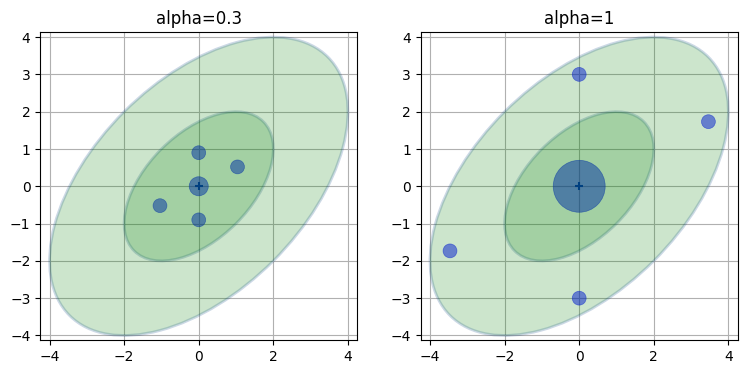

In [15]:
ukf_internal.plot_sigma_points()

我们可以看到，西格玛点位于第一和第二标准差之间，而较大的 $\alpha$ 会使这些点更分散。此外，较大的 $\alpha$ 会比较小的 $\alpha$ 更高地赋予平均值（中心点）权重，并给其他点赋予较小的权重。这符合我们的直觉——点距离均值越远，我们赋予它的权重就应该越小。虽然我们还不知道如何选择这些权重和西格玛点，但这些选择看起来是合理的。

# sigma点计算

第一个西格玛点是输入的均值。这是上图中椭圆中心显示的西格玛点。我们将其称为 $\boldsymbol{\chi}_0$。

$$ \mathcal{X}_0 = \mu$$

为了方便表示，我们定义 $\lambda = \alpha^2(n+\kappa)-n$，其中 $n$ 是 $\mathbf x$ 的维数。其余的西格玛点计算如下：

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$
这里的 $i$ 下标选择了矩阵的第 $i$ 行向量。

换句话说，我们通过一个常数缩放协方差矩阵，对其进行平方根处理，并通过将其加减均值来保证对称性。我们将在后面讨论如何对矩阵进行平方根处理。

# 权重计算

这个公式使用一组权重用于均值，另一组用于协方差。对于 $\mathcal{X}_0$ 的均值，权重计算如下：

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

对于 $\mathcal{X}_0$ 的协方差，权重为

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

对于其余的西格玛点 $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$，均值和协方差的权重相同。它们是

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

这为何是“正确”的可能不是很明显，实际上，无法证明这对于所有非线性问题都是理想的。但你可以看到我们选择的西格玛点与协方差矩阵的平方根成比例，并且方差的平方根是标准差。因此，西格玛点大致按照 $\pm 1\sigma$ 乘以某个缩放因子进行展开。分母中有一个 $n$ 项，因此随着维数的增加，点会展开并且权重会减小。

**重要提示：** 通常这些权重不会加和为一。我收到很多关于这个问题的提问。权重的总和大于一，甚至为负数是正常的。我将在下面更详细地介绍这一点。

# 参数的合理选择

$\beta=2$ 对于高斯问题是一个不错的选择，$\kappa=3-n$ 其中 $n$ 是 $\mathbf x$ 的维数是 $\kappa$ 的一个不错的选择，$0 \le \alpha \le 1$ 对于 $\alpha$ 是一个合适的选择，其中较大的 $\alpha$ 值会使西格玛点距离均值更远。

# 使用无迹卡尔曼滤波器

让我们解决一些问题，这样你就能对使用UKF有多简单获得信心了。我们将从一个线性问题开始，这是你已经知道如何使用线性卡尔曼滤波器解决的问题。尽管UKF是为非线性问题设计的，但对于线性问题，它找到的最优结果与线性卡尔曼滤波器相同。我们将编写一个滤波器来跟踪一个二维物体，使用恒定速度模型。这将使我们能够专注于相同之处（大部分都是相同的！）以及与UKF不同的地方。

设计卡尔曼滤波器需要你指定$\bf{x}$、$\bf{F}$、$\bf{H}$、$\bf{R}$和$\bf{Q}$矩阵。我们已经做过很多次了，所以我会直接给你这些矩阵而不多讨论。我们希望一个恒定速度模型，因此我们定义$\bf{x}$为

$$ \mathbf x = \begin{bmatrix}x &  \dot x & y & \dot y \end{bmatrix}^\mathsf{T}$$

在这个状态变量排序下，状态转移矩阵是

$$\mathbf F = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

它实现了牛顿方程

$$\begin{aligned}
x_k &= x_{k-1} + \dot x_{k-1}\Delta t \\
y_k &= y_{k-1} + \dot y_{k-1}\Delta t
\end{aligned}$$

我们的传感器提供位置但不提供速度，因此测量函数是

$$\mathbf H = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

传感器读数以米为单位，在*x*和*y*方向上的误差为$\sigma=0.3$米。这给我们一个测量噪声矩阵为

$$\mathbf R = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

最后，让我们假设过程噪声可以用离散白噪声模型来表示 - 也就是说，每个时间段内加速度是恒定的。我们可以使用`FilterPy`的`Q_discrete_white_noise()`来为我们创建这个矩阵，但为了复习一下，该矩阵是

$$\mathbf Q = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

我的这个滤波器的实现是：

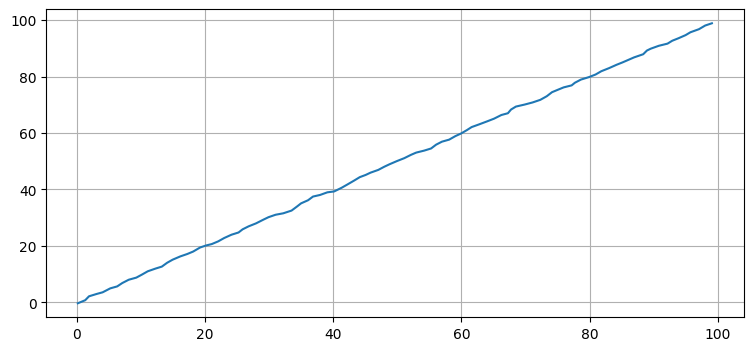

In [16]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y = .3, .3
dt = 1.0

np.random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([std_x**2, std_y**2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2]);

这应该对你来说不会有什么意外。现在让我们实现一个UKF。同样，这纯粹是为了教育目的；对于线性问题使用UKF并没有好处。`FilterPy`使用`UnscentedKalmanFilter`类来实现UKF。

首先要做的是实现函数`f(x, dt)`和`h(x)`。`f(x, dt)`实现状态转移函数，`h(x)`实现测量函数。这对应于线性滤波器中的矩阵$\mathbf F$和$\mathbf H$。

下面是这两个函数的合理实现。每个函数都应返回包含结果的一维NumPy数组或列表。你可以给它们比`f`和`h`更可读的名字。

In [17]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x):
    return x[[0, 2]]

接下来，你需要指定如何计算sigma点和权重。我们之前提到了范德默维的版本，但有许多不同的选择。FilterPy使用一个名为`SigmaPoints`的类，它必须实现一个方法：

```python
def sigma_points(self, x, P)
```

并包含`Wm`和`Wc`属性，分别用于计算均值和协方差的权重。

FilterPy从`SigmaPoints`派生出`MerweScaledSigmaPoints`类，并实现了上述方法。

当你创建UKF时，你将传入$f()$和$h()$函数以及sigma点对象，就像这个例子中一样：

```python
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, points=points)
```

其余的代码与线性卡尔曼滤波器相同。我将使用相同的测量并计算两个解之间差异的标准偏差。

UKF standard deviation 0.013 meters


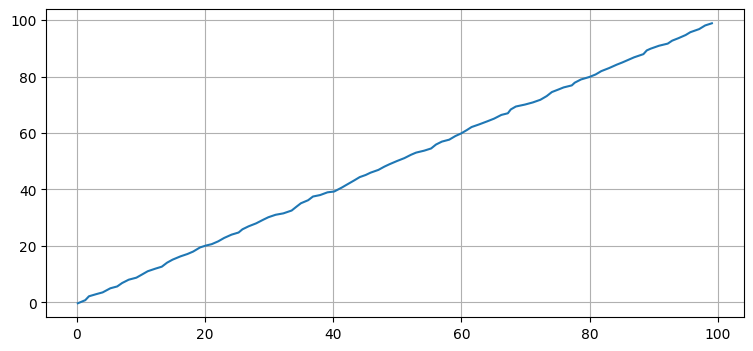

In [18]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')

这给出了一个标准偏差为0.013米的结果，非常小。

UKF的实现与线性卡尔曼滤波器并没有太大的不同。你不是使用矩阵$\mathbf F$和$\mathbf H$来实现状态转移和测量函数，而是提供非线性函数`f()`和`h()`。理论和实现的其余部分保持不变。`predict()`和`update()`的代码实现不同，但从设计者的角度来看，问题的表述和滤波器设计非常相似。

# 追踪飞机

很好，我们来解决我们的第一个非线性问题。我们将编写一个用雷达作为传感器来跟踪飞机的滤波器。为了尽可能保持问题与之前的问题相似，我们将在二维空间中进行跟踪。我们将跟踪地面上的一个维度和飞机的高度。每个维度都是独立的，所以我们可以这样做而不失一般性。

雷达工作原理是通过发射无线电波或微波。波束路径上的任何物体都会将部分信号反射回雷达。通过计算反射信号返回所需的时间，可以计算出到目标的 *斜距*。斜距是从雷达到物体的直线距离。方位角是使用天线的 *指向增益* 来计算的。

我们通过斜距和仰角计算飞机的(x,y)位置，如下图所示：

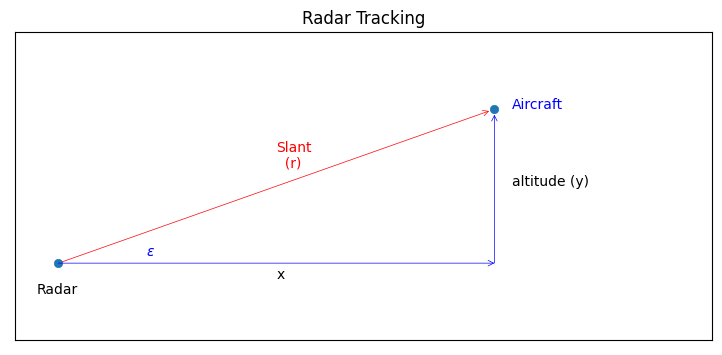

In [19]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_radar_chart()

*仰角* $\epsilon$ 是形成与地面的视线的夹角。

我们假设飞机以恒定高度飞行。因此，我们有一个三个变量的状态向量：

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

状态转移函数是线性的：

$$\mathbf{\bar x} = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}
$$

可以通过以下方式计算：

In [20]:
def f_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

接下来我们设计测量函数。和线性卡尔曼滤波器一样，测量函数将滤波器的先验转换为一个测量值。我们需要将飞机的位置和速度转换成雷达站的仰角和距离。

距离可以用勾股定理计算：

$$\text{range} = \sqrt{(x_\text{ac} - x_\text{radar})^2 + (y_\text{ac} - y_\text{radar})^2}$$

仰角 $\epsilon$ 是 $y/x$ 的反正切：

$$\epsilon = \tan^{-1}{\frac{y_\text{ac} - y_\text{radar}}{x_\text{ac} - x_\text{radar}}}$$

我们需要定义一个Python函数来计算这个值。我会利用函数可以拥有一个变量来存储雷达的位置。虽然这对于这个问题来说并不是必需的（我们可以硬编码该值，或者使用全局变量），但这样可以增加函数的灵活性。

In [21]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

我们没有考虑到一个非线性因素，那就是角度是循环的。残差是测量值和先验之间的差异，投影到测量空间。359°和1°之间的角度差是2°，但359° - 1° = 358°。这在UKF中会更加明显，因为UKF计算非线性变换中加权值的和。现在我们将把传感器和目标放在避开这些非线性区域的位置。稍后我会向你展示如何处理这个问题。

我们需要模拟雷达和飞机。现在这对你来说应该已经驾轻就熟了，所以我提供代码而不进行讨论。

In [22]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

一个军用级别的雷达可以实现1米的距离精度和1毫弧度的仰角精度[3]。我们将假设更为适度的5米距离精度和0.5°的角度精度，因为这会为滤波器提供更具挑战性的数据集。

$\mathbf Q$ 的设计需要一些讨论。状态向量是 $\begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$。前两个元素是下行距离和速度，所以我们可以使用`Q_discrete_white_noise`来计算Q的左上角的值。第三个元素是高度，我们假设它与$x$是独立的。这导致了$\mathbf Q$ 的分块设计：

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & \boldsymbol 0 \\ \boldsymbol 0 & Q_\mathtt{y}\end{bmatrix}$$

我会从飞机直接位于雷达站上方，以100米/秒的速度飞行开始。一个典型的高度雷达可能每3秒只更新一次，所以我们将使用这个作为我们的时间间隔。

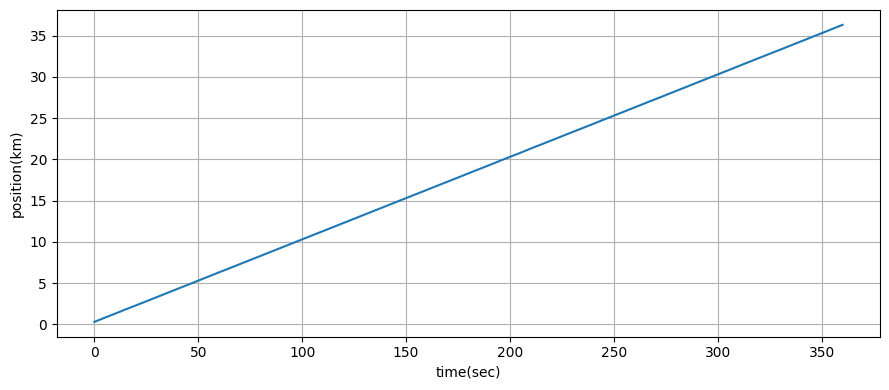

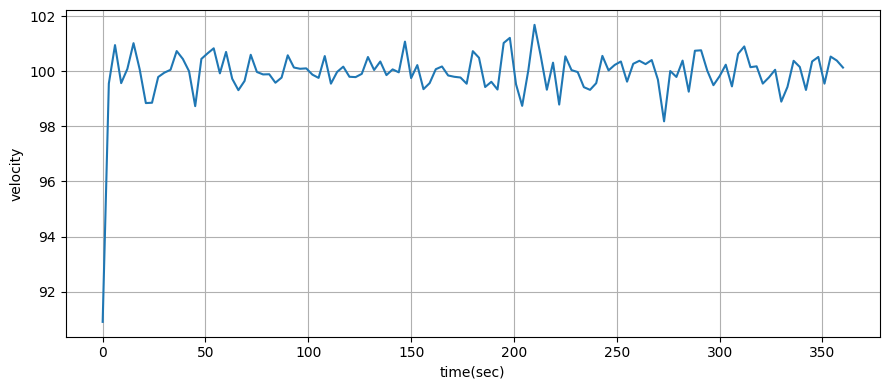

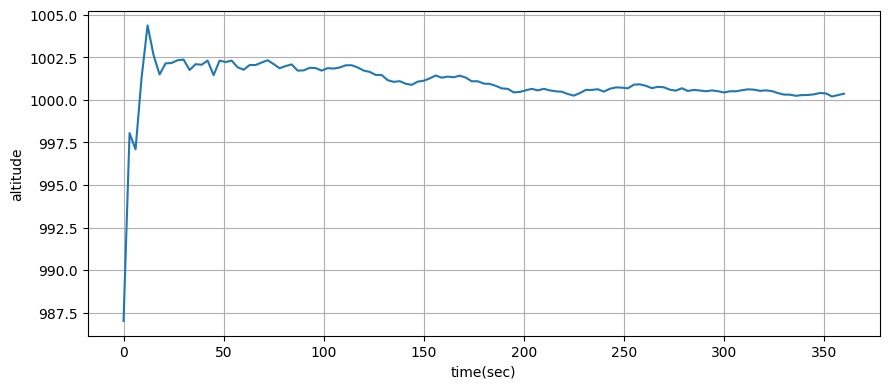

In [45]:
import math
from kf_book.ukf_internal import plot_radar

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, elevation_angle_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)
plot_radar(xs, time)

或许这不一定能让你感到印象深刻，但它却让我感到印象深刻！在扩展卡尔曼滤波的章节中，我们将解决同样的问题，但需要大量的数学计算。

# 追踪机动飞机

前面的例子产生了不错的结果，但假设飞机不改变高度。如果飞机在一分钟后开始爬升，这里是滤波器的结果。

Actual altitude: 2515.6
UKF altitude   : 1042.1


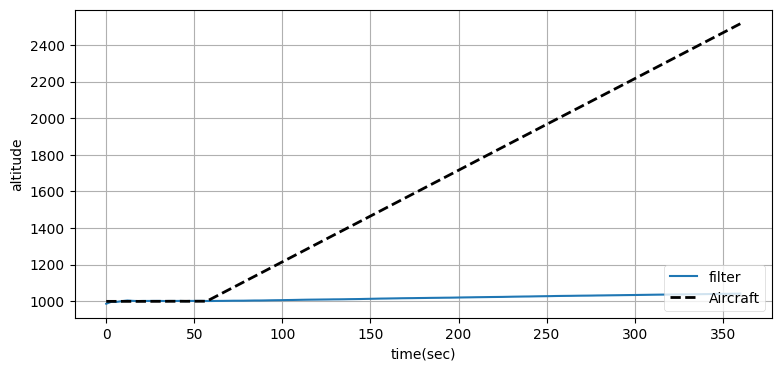

In [24]:
from kf_book.ukf_internal import plot_altitude

# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

滤波器无法跟踪高度的变化。我们需要在设计中做出哪些改变呢？

希望你的回答是：“将爬升速率加入状态变量中”，就像这样：

$$\mathbf x = \begin{bmatrix}\mathtt{距离} \\\mathtt{速度}\\ \mathtt{高度} \\ \mathtt{爬升率}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

这需要对状态转移函数进行以下更改，仍然是线性的：

$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&\Delta t \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot x\\ y\\ \dot y\end{bmatrix} 
$$

测量函数保持不变，但我们必须改变 $\mathbf Q$ 来适应 $\mathbf x$ 维度的变化。

In [25]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft"""
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return F @ x
    
def cv_UKF(fx, hx, R_std):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
    kf = UKF(4, len(R_std), dt, fx=fx, hx=hx, points=points)

    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.R = np.diag(R_std)
    kf.R = kf.R @ kf.R  # square to get variance
    kf.x = np.array([0., 90., 1100., 0.])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

Actual altitude: 2515.6
UKF altitude   : 2500.1


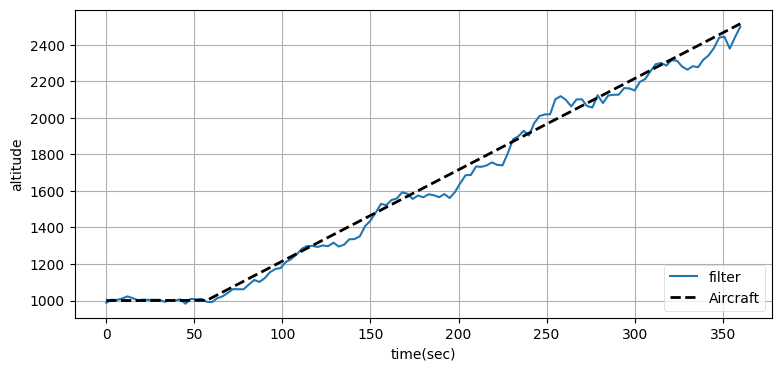

In [26]:
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_cv = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf_cv.predict()
    kf_cv.update([r[0], r[1]]) 
    xs.append(kf_cv.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

高度估计引入了大量噪音，但我们现在能够准确跟踪高度。

# 传感器融合

多普勒系统利用多普勒效应来测量物体相对于传感器的速度。多普勒效应是当物体相对于观察者运动时引起的频率变化现象。对于运动物体发出的波（比如声波或电磁波），如果物体向传感器靠近，波的频率会增加；如果物体远离传感器，波的频率会减小。

在雷达和多普勒测速仪等系统中，多普勒效应被利用来测量物体的速度。例如，在车辆上安装的雷达可以利用多普勒效应来测量其他车辆的速度。多普勒系统发送波束（如电磁波），当这些波束与物体相互作用并被反射回来时，系统会分析波的频率变化，从而推断出物体相对于传感器的速度。

在传感器融合中，将多普勒系统与其他传感器结合使用可以提供更全面和准确的信息，尤其是在需要高精度速度测量的应用中，如导航、运动控制和监测等领域。

现在我们考虑一个传感器融合的例子。我们有某种类型的多普勒系统，它以2 m/s的RMS精度产生速度估计。我说“某种类型”是因为和雷达一样，我不是在教你如何为多普勒系统创建一个精确的滤波器。一个完整的实现必须考虑到信噪比、大气效应、系统的几何形状等因素。

在上面的例子中，雷达的精度让我们能够将速度估计到大约1 m/s左右，我会降低那个精度以展示传感器融合的效果。让我们将距离误差改为$\sigma=500$米，然后计算估计速度的标准偏差。我会跳过前面的几个测量，因为在那段时间内滤波器正在收敛，导致人为地产生了较大的偏差。

不使用多普勒时的标准偏差是：

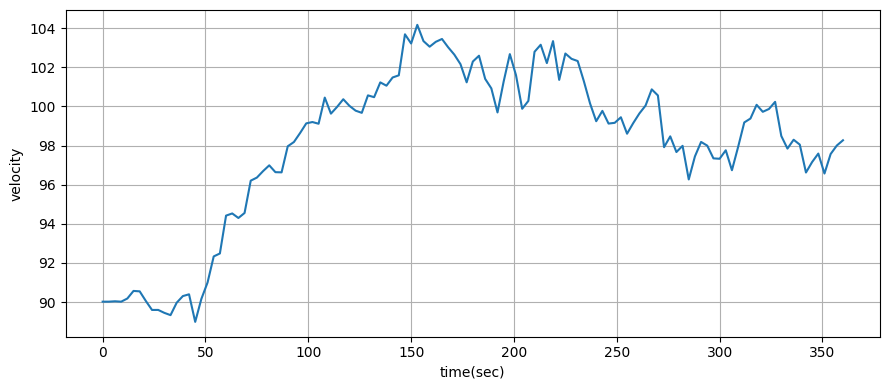

Velocity std 3.4 m/s


In [44]:
range_std = 500.
elevation_angle_std = math.degrees(0.5)
np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_sf = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf_sf.predict()
    kf_sf.update([r[0], r[1]]) 
    xs.append(kf_sf.x)

xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:, 1]):.1f} m/s')

对于多普勒，我们需要将$x$和$y$中的速度包含在测量中。`ACSim`类将速度存储在数据成员`vel`中。要执行卡尔曼滤波器更新，我们只需要使用包含斜距、仰角以及$x$和$y$中的速度的列表调用`update`方法：

$$z = [\mathtt{slant\_range},\, \text{elevation angle},\, \dot x,\, \dot y]$$

测量包含四个值，因此测量函数也需要返回四个值。斜距和仰角将像以前一样计算，而且我们不需要计算$x$和$y$中的速度，因为它们已经由状态估计提供了。

In [46]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    elevation_angle = math.atan2(dz, dx)
    return slant_range, elevation_angle, x[1], x[3]

现在我们可以实现滤波器了

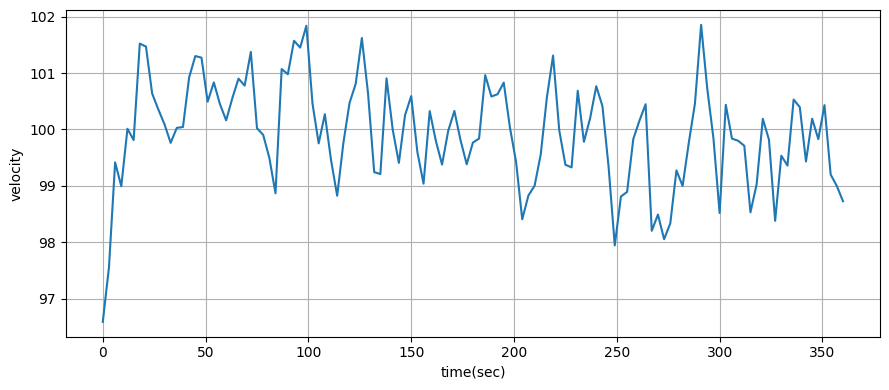

Velocity std 0.9 m/s


In [49]:
h_radar.radar_pos = (0, 0)
h_vel.radar_pos = (0, 0)

range_std = 500.
elevation_angle_std = math.degrees(0.5)
vel_std = 2.

np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)
radar = RadarStation((0, 0), range_std, elevation_angle_std)

kf_sf2 = cv_UKF(f_cv_radar, h_vel, 
            R_std=[range_std, elevation_angle_std, vel_std, vel_std])

time = np.arange(0, 360 + dt, dt)
xs = []
for t in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    # simulate the doppler velocity reading
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf_sf2.predict()
    kf_sf2.update([r[0], r[1], vx, vz]) 
    xs.append(kf_sf2.x)
xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:,1]):.1f} m/s')

通过引入速度传感器，我们成功将标准偏差从3.5米/秒减少到了1.3米/秒。

传感器融合是一个广泛的话题，而这只是一个相当简单的实现。在典型的导航问题中，我们拥有提供互补信息的传感器。例如，GPS可能每秒提供一次相对准确的位置更新，但速度估计较差；而惯性系统可能以50Hz提供非常精确的速度更新，但位置估计却很糟糕。每个传感器的优势和劣势是彼此正交的。这就引出了“互补滤波器”，它将高更新率的惯性速度测量与GPS精确但更新速度较慢的位置估计结合起来，产生高速率和准确的位置与速度估计。高速率的速度估计在GPS更新之间进行积分，以产生准确且高速率的位置估计。

# 多位置传感器

前面那个传感器融合问题只是一个玩具般的例子。我们来解决一个不那么简单的问题。在GPS出现之前，船舶和飞机通过各种测距和方位系统导航，比如VOR、LORAN、TACAN、DME等等。这些系统发射无线电波信标。传感器从信号中提取信标的距离和/或方位。例如，一架飞机可能有两个VOR接收器。飞行员调配每个接收器到不同的VOR站。每个VOR接收器显示射线 - 即从地面VOR站到飞机的方向。飞行员使用地图找到射线的交汇点，从而确定飞机的位置。

这是一种手动方法，精度较低。而卡尔曼滤波器将产生更准确的位置估计。假设我们有两个传感器，每个传感器只提供到目标的方位测量，就像下面的图表所示。边界的宽度与传感器噪声的$3\sigma$成比例。飞机必须位于两个边界交集的位置上，且具有较高的概率性。

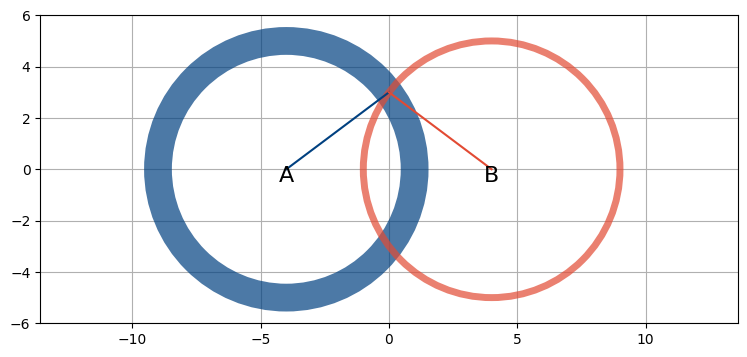

In [50]:
ukf_internal.show_two_sensor_bearing()

我们计算传感器与目标之间的方位角为：

In [51]:
def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])

滤波器接收来自两个传感器的测量值组成的向量。代码可以接受任何可迭代的容器，为了效率起见，我使用了Python列表。我们可以这样实现：

In [52]:
def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

假设飞行器采用恒定速度模型。为了变换步调，我会明确计算新的位置，而不是使用矩阵-向量乘法：

In [53]:
def fx_VOR(x, dt):
    x[0] += x[1] * dt
    x[2] += x[3] * dt
    return x

接下来我们实现测量函数。它将先前的状态转换为一个包含对两个站点的测量的数组。我不是很喜欢全局变量，但我将站点的位置放在全局变量 `sa_pos` 和 `sb_pos` 中，以演示使用$h()$共享数据的这种方法：

In [54]:
sa_pos = [-400, 0]
sb_pos = [400, 0]

def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)

现在我们编写模板代码，用于构建滤波器、运行它并绘制结果：

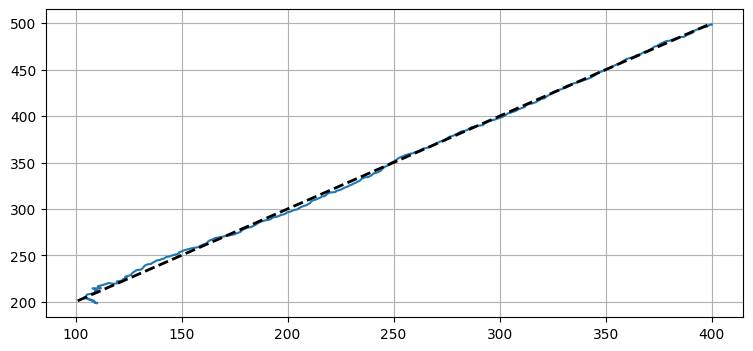

In [55]:
def moving_target_filter(pos, std_noise, Q, dt=0.1, kappa=0.0):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 1000    
    return f

def plot_straight_line_target(f, std_noise):
    xs, txs = [], []
    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[:, 0], txs[:, 1], ls='--', lw=2, c='k')
    plt.show()

np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

这看起来相当不错。轨迹开始时出现较大误差，但滤波器稳定下来后产生了良好的估计。

让我们重新考虑角度的非线性。我会将目标放置在两个传感器之间的位置为(0,0)的地方。这将导致在残差计算中出现非线性，因为平均角度将接近于零。当角度小于0时，测量函数将计算出接近于$2\pi$的大正角。因此，预测和测量之间的残差将非常大，几乎为$2\pi$而不是接近0。这使得滤波器无法准确执行，就像下面的例子中所示。

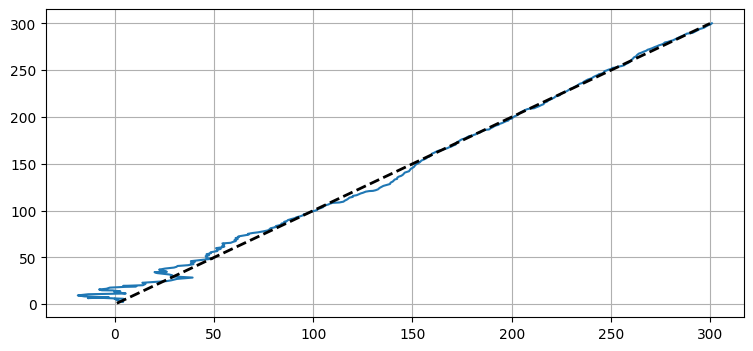

In [56]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

这种表现是不可接受的。`FilterPy`的UKF代码允许您指定一个函数来计算残差，以处理这种非线性行为的情况。本章的最后一个示例演示了它的用法。

# 传感器误差和几何形状的影响

传感器相对于被跟踪物体的几何位置会施加物理限制，在设计滤波器时可能会非常困难。如果VOR站的射线几乎平行，则非常小的角度误差会转化为非常大的距离误差。更糟糕的是，这种行为是非线性的 - 在实际方位中，*x轴*与*y轴*的误差会有所不同。这些散点图展示了两个不同方位下1°$\sigma$误差的误差分布。

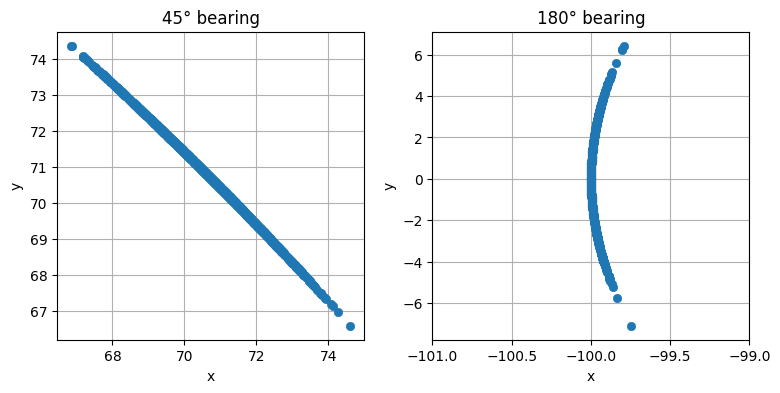

In [57]:
ukf_internal.plot_scatter_of_bearing_error()

# 练习：解释滤波器性能

我们可以看到，对于小的角度误差，位置误差非常大。请解释一下在上述目标跟踪问题中我们是如何取得相对良好的UKF性能的。请分别回答单传感器和多传感器问题。

# 答案

这一点非常重要，要在看下面的答案之前尽量努力回答。如果你回答不出来，可能需要重新查看**多维卡尔曼滤波器**章节中的一些早期内容。

有几个因素有助于我们的成功。首先，让我们考虑只有一个传感器的情况。任何单一测量都有极大范围的可能位置。但是，我们的目标在移动，而UKF正在考虑这一点。让我们绘制一系列针对移动目标进行的多次测量的结果。

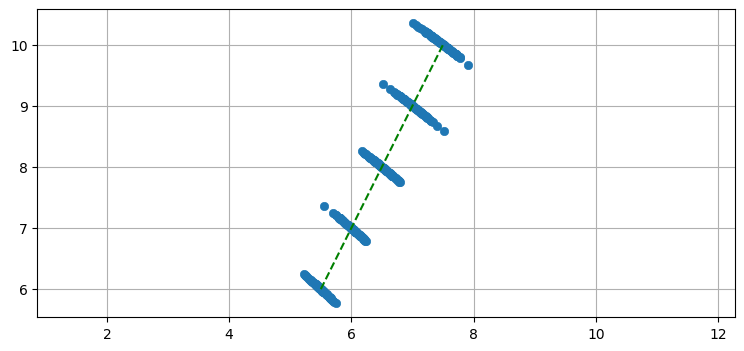

In [58]:
ukf_internal.plot_scatter_moving_target()

每个单独的测量都具有非常大的位置误差。然而，连续测量的图表显示了一个明显的趋势——目标显然朝着右上方移动。当卡尔曼滤波器计算卡尔曼增益时，它通过使用测量函数考虑误差的分布情况。在这个例子中，误差大致在一个45°的线上，因此滤波器将削减该方向上的误差。另一方面，在垂直于该方向的测量中几乎没有误差，卡尔曼增益将再次考虑到这一点。

这张图表看起来很容易，因为我们为每个位置更新绘制了100次测量。飞行器的移动是明显的。相比之下，卡尔曼滤波器每次更新只获得一个测量。因此，滤波器将无法生成与虚线绿线所暗示的那样良好的拟合。

现在考虑一下，方位角并未提供距离信息。假设我们将初始估计设置为距离传感器1,000公里的位置（实际距离为7.07公里），并且将 $\mathbf P$ 设置得非常小。在那个距离上，1°的误差会导致17.5公里的位置误差。由于滤波器对其位置估计非常确定，而且测量中没有提供距离信息，因此卡尔曼滤波器永远无法收敛到实际的目标位置。

现在让我们考虑添加第二个传感器的影响。这里有两个图表，显示了不同传感器放置的效果。我使用正方形和三角形作为两个传感器的符号，并使用相同的符号形状和颜色绘制了由每个传感器引起的误差分布。然后，我计算了与两个嘈杂的方位角测量相对应的$(x, y)$坐标，并用红点绘制它们，以显示$x$和$y$中嘈杂测量的分布。

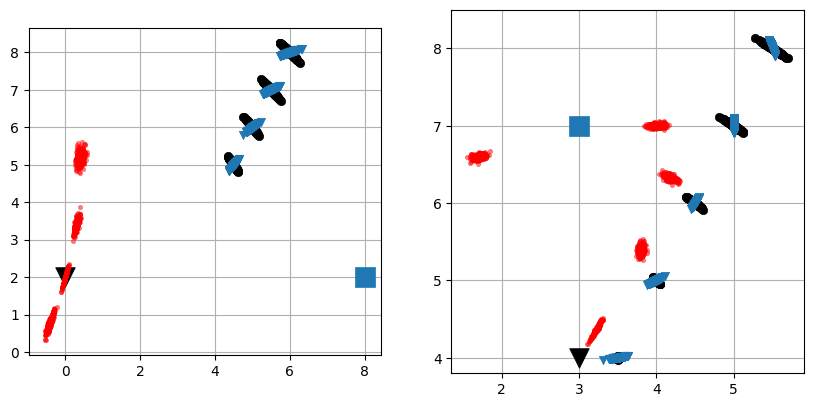

In [59]:
with figsize(10,5):
    ukf_internal.plot_iscts_two_sensors()

在第一个图表中，我将传感器几乎放置在与目标初始位置几乎正交的位置，所以我们得到了这些可爱的“x”形交点。我们可以通过散落的红点的形状来看到随着目标移动，$x$和$y$中的误差是如何变化的——随着目标远离传感器，但接近传感器B的$y$坐标时，形状变得非常椭圆。

在第二个图表中，飞机初始位置非常靠近一个传感器，然后飞过第二个传感器。误差的交叉点非常非正交，导致的位置误差变得非常分散。

# 无迹卡尔曼滤波器的使用

FilterPy实现了UKF，但学习如何将方程式转化为代码是很有益的。实现UKF相当简单。首先，让我们编写代码来计算sigma点的均值和协方差。

我们将把sigma点和权重存储在矩阵中，如下所示：

$$ 
\begin{aligned}
\text{weights} &= 
\begin{bmatrix}
w_0& w_1 & \dots & w_{2n}
\end{bmatrix} 
\\
\text{sigmas} &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} & \dots & \mathcal{X}_{0,n-1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \dots & \mathcal{X}_{1,n-1} \\
\vdots & \vdots &  \ddots & \vdots \\
\mathcal{X}_{2n,0} & \mathcal{X}_{2n,1} & \dots & \mathcal{X}_{2n,n-1}
\end{bmatrix}
\end{aligned}
$$

这里有很多下标来描述一些非常简单的东西，所以这里有一个二维问题（$n$=2）的示例：

In [60]:
points = MerweScaledSigmaPoints(n=2, alpha=.1, beta=2., kappa=1.)
points.sigma_points(x=[0.,0], P=[[1.,.1],[.1, 1]])

array([[ 0.   ,  0.   ],
       [ 0.173,  0.017],
       [ 0.   ,  0.172],
       [-0.173, -0.017],
       [ 0.   , -0.172]])

均值的sigma点在第一行。它的位置是（0, 0），与均值（0, 0）相等。第二个sigma点位于（0.173, 0.017），依此类推。总共有$2n+1=5$行，每个sigma点占一行。如果$n=3$，那么将会有3列和7行。

选择将sigma点存储在行-列格式还是列-行格式在某种程度上是任意的；我的选择使得代码的其余部分更清晰，因为我可以将第i个sigma点表示为`sigmas[i]`而不是`sigmas[:, i]`。

# 权重

用NumPy计算权重很容易。回想一下Van der Merwe缩放的sigma点实现规定：

$$
\begin{aligned}
\lambda&=\alpha^2(n+\kappa)-n \\ 
W^m_0 &= \frac{\lambda}{n+\lambda} \\
W^c_0 &= \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta \\
W^m_i = W^c_i &= \frac{1}{2(n+\lambda)}\;\;\;i=1..2n
\end{aligned}
$$

对应的代码如下：

```python
lambda_ = alpha**2 * (n + kappa) - n
Wc = np.full(2*n + 1, 1. / (2*(n + lambda_)))
Wm = np.full(2*n + 1, 1. / (2*(n + lambda_)))
Wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
Wm[0] = lambda_ / (n + lambda_)
```

我在`lambda_`中使用下划线是因为`lambda`在Python中是一个保留字。在末尾加下划线是Python的一种解决方法。

# sigma 点

方程中的sigma点为：

$$
\begin{cases}
\mathcal{X}_0 = \mu \\
\mathcal{X}_i = \mu +  \left[\sqrt{(n+\lambda)\Sigma} \right]_i, & i=1..n \\
\mathcal{X}_i = \mu - \left[\sqrt{(n+\lambda)\Sigma}\right]_{i-n} & i=(n+1)..2n
\end{cases}
$$

一旦我们理解了 $\left[\sqrt{(n+\lambda)\Sigma}  \right]_i$ 术语，Python 就不难了。

术语 $\sqrt{(n+\lambda)\Sigma}$ 是一个矩阵，因为 $\Sigma$ 是一个矩阵。在 $[\sqrt{(n+\lambda)\Sigma}]_i$ 中的下标 $i$ 选择了矩阵的第 $i$ 行向量。矩阵的平方根是什么？没有唯一的定义。一种定义是矩阵 $\Sigma$ 的平方根是矩阵 $S$，当与自身相乘时得到 $\Sigma$：如果 $\Sigma = SS$，那么 $S = \sqrt{\Sigma}$。

我们将选择一种使计算更容易的替代定义。我们可以将平方根定义为矩阵 $S$，当与其转置相乘时，返回 $\Sigma$：

$$
\Sigma = \mathbf{SS}^\mathsf T
$$

这个定义更受青睐，因为 $\mathbf S$ 使用[*Cholesky分解*](https://en.wikipedia.org/wiki/Cholesky_decomposition)[5]进行计算。它将Hermitian正定矩阵分解为一个三角矩阵和其共轭转置。矩阵可以是上三角或下三角的，就像这样：

$$A=LL^{∗} \\ A=U^{∗}U$$

星号表示共轭转置；我们只有实数，所以对于我们来说可以写成：

$$A=LL^\mathsf T \\ A=U^\mathsf T U$$

$\mathbf P$ 具有这些属性，因此我们可以将 $\mathbf S = \text{cholesky}(\mathbf P)$ 视为 $\mathbf P$ 的平方根。

SciPy 在 `scipy.linalg` 中提供了 `cholesky()` 方法。如果你选择的语言是Fortran、C或C++，类似 LAPACK 这样的库提供了这个例程。Matlab 提供了 `chol()`。

默认情况下，`scipy.linalg.cholesky()` 返回一个上三角矩阵，所以我选择编写代码以期望一个上三角矩阵。因此，我通过行访问结果，这样第一个sigma点，即中心点，受到一个完整的非零值行的影响。如果你提供自己的平方根实现，你需要考虑这一点。在文献中你会发现采用按列优先的 UKF 算法。如果 cholesky 是下三角的，或者如果你使用了计算对称矩阵的不同算法，那么行与列的顺序就不重要了。

In [61]:
import scipy
a = np.array([[2., .1], [.1, 3]])
s = scipy.linalg.cholesky(a)
print("cholesky:")
print(s)
print("\nsquare of cholesky:")
print(s @ s.T)

cholesky:
[[1.414 0.071]
 [0.    1.731]]

square of cholesky:
[[2.005 0.122]
 [0.122 2.995]]


所以我们可以用这段代码实现sigma点：

```python
sigmas = np.zeros((2*n+1, n))
U = scipy.linalg.cholesky((n+lambda_)*P) # 开方

sigmas[0] = X
for k in range (n):
    sigmas[k+1]   = X + U[k]
    sigmas[n+k+1] = X - U[k]
```

现在让我们实现无损传递变换。回忆方程：

$$\begin{aligned}
\mu &= \sum_i w_i^m\mathcal{X}_i \\
\Sigma &= \sum_i w_i^c{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

我们用以下代码实现均值之和：

```python
x = np.dot(Wm, sigmas)
```

如果你不是 NumPy 的重度用户，这可能对你来说很陌生。NumPy 不仅仅是使线性代数成为可能的库；在内部，它是用 C 和 Fortran 编写的，以实现比 Python 更快的速度。典型的加速是20倍到100倍。为了获得这种加速，我们必须避免使用 for 循环，而是使用 NumPy 的内置函数来执行计算。因此，我们不是编写一个 for 循环来计算乘积之和，而是调用内置的 `numpy.dot(x, y)` 方法。两个向量的点积是每个元素的按元素乘积之和。如果传递了一个一维数组和一个二维数组，它将计算内积的和：

In [62]:
a = np.array([10, 100])
b = np.array([[1, 2, 3],
              [4, 5, 6]])
np.dot(a, b)

array([410, 520, 630])

最后要计算 $\mathbf P = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf Q$：

```python
kmax, n = sigmas.shape
P = zeros((n, n))
for k in range(kmax):
    y = sigmas[k] - x
    P += Wc[k] * np.outer(y, y) 
P += Q
```

这介绍了 NumPy 的另一个特性。状态变量 `x` 是一维的，`sigmas[k]` 也是一维的，所以差值 `sigmas[k]-X` 也是一维的。NumPy 不会计算 1-D 数组的转置；它认为 `[1,2,3]` 的转置是 `[1,2,3]`。因此，我们调用函数 `np.outer(y,y)` 计算 1D 数组 $\mathbf{y}$ 的 $\mathbf{yy}^\mathsf{T}$ 值。另一种实现可能是：

```python
y = (sigmas[k] - x).reshape(kmax, 1) # 转换成二维数组
P += Wc[K] * np.dot(y, y.T)
```

这段代码速度较慢，不够常见，所以我们不会使用它。

# 预测步骤

在预测步骤中，我们将按照上面的规定生成权重和sigma点。我们将每个sigma点通过函数 f。

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

然后，我们使用无损传递变换来计算预测的均值和协方差。在下面的代码中，你可以看到我假设这是存储滤波器所需的各种矩阵和向量的类中的一个方法。

```python
def predict(self, sigma_points_fn):
    """ Performs the predict step of the UKF. On return, 
    self.xp and self.Pp contain the predicted state (xp) 
    and covariance (Pp). 'p' stands for prediction.
    """

    # calculate sigma points for given mean and covariance
    sigmas = sigma_points_fn(self.x, self.Pp)

    for i in range(self._num_sigmas):
        self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

    self.xp, self.Pp = unscented_transform(
                       self.sigmas_f, self.Wm, self.Wc, self.Q)
```

# 更新步骤

更新步骤通过函数 `h(x)` 将 sigma 点转换为测量空间。

$$\mathcal{Z} = h(\mathcal{Y})$$

然后，使用无损传递变换计算这些点的均值和协方差。接着计算残差和卡尔曼增益。交叉方差计算如下：

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mu)(\boldsymbol{\mathcal Z}_i-\mu_z)^\mathsf T$$

最后，使用残差和卡尔曼增益计算新的状态估计：

$$\begin{aligned}
K &= \mathbf P_{xz} \mathbf P_z^{-1}\\
{\mathbf x} &= \mathbf{\bar x} + \mathbf{Ky}
\end{aligned}$$

新的协方差计算如下：

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP}_z\mathbf{K}^\mathsf{T}$$

这个函数可以如下实现，假设它是一个存储必要矩阵和数据的类的方法。


```python
def update(self, z):
    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through UT
    zp, Pz = unscented_transform(sigmas_h, self.Wm, self.Wc, self.R)

    # compute cross variance of the state and the measurements
    Pxz = np.zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.Wc[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = np.dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + np.dot(K, z - zp)
    self.P = self.Pp - np.dot(K, Pz).dot(K.T)
```

# FilterPy的实现

FilterPy对代码进行了一定的泛化。你可以指定不同的sigma点算法，指定如何计算状态变量的残差（你不能简单地减去角度，因为它们是模的），提供矩阵平方根函数等。详情请参阅帮助文档。

https://filterpy.readthedocs.org/#unscented-kalman-filter

# 批量处理

将你的测量收集到一个数组或列表中。

```python
zs = read_altitude_from_csv()
```

然后调用 `batch_filter()` 方法。

```python
Xs, Ps = ukf.batch_filter(zs)
```

这个函数接受测量值的列表/数组，对其进行过滤，并返回整个数据集的状态估计数组（`Xs`）和协方差矩阵数组（`Ps`）。

以下是一个完整的示例，来自上述的雷达跟踪问题。

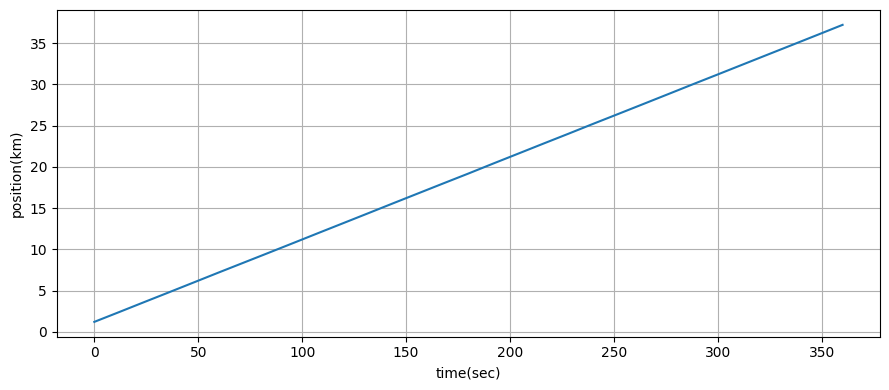

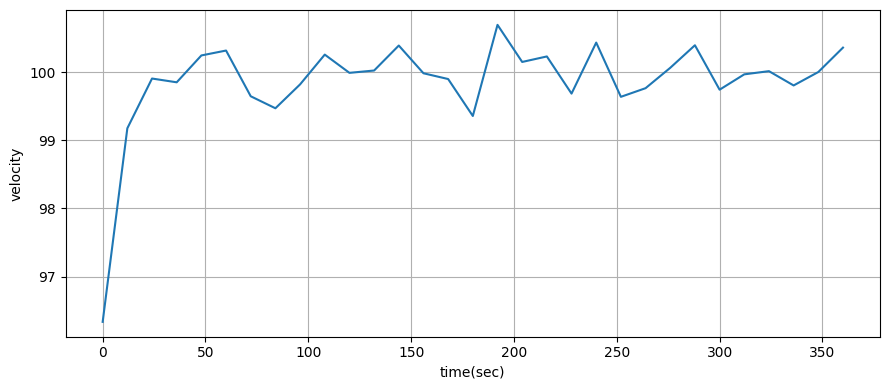

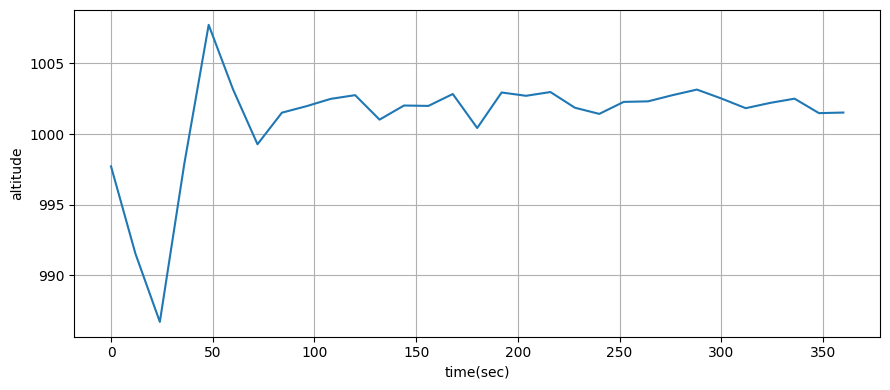

In [63]:
dt = 12. # 12 seconds between readings
range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2 ,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2, 2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

radar = RadarStation((0, 0), range_std, bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

zs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    zs.append([r[0], r[1]])

xs, covs = kf.batch_filter(zs)
ukf_internal.plot_radar(xs, t)

# 对结果进行平滑处理

假设我们正在追踪一辆车。假设我们得到一个嘈杂的测量结果，表明车开始向左转，但状态函数预测车在直线行驶。卡尔曼滤波器别无选择，只能将状态估计略微朝着嘈杂的测量结果移动，因为它无法判断这是一个特别嘈杂的测量还是真正开始转弯。

如果我们正在收集数据并进行后处理，我们在可疑的测量之后有一些测量可以告诉我们是否发生了转弯。假设随后的测量都持续向左转。那么我们可以肯定这个测量并不是很嘈杂，而是真的开始了转弯。

我们在这里不会展开数学或算法，我只会向你展示如何在 `FilterPy` 中调用算法。我们实现的算法称为*RTS平滑器*，得名于该算法的三位发明者：Rauch、Tung 和 Striebel。

这个程序是 `UnscentedKalmanFilter.rts_smoother()`。使用它非常简单；我们传入从`batch_filter`步骤计算得到的均值和协方差，然后得到平滑后的均值、协方差和卡尔曼增益。

Difference in position in meters:
	 [-1.4166 -0.2815  1.2679 -1.2405 -2.1863]


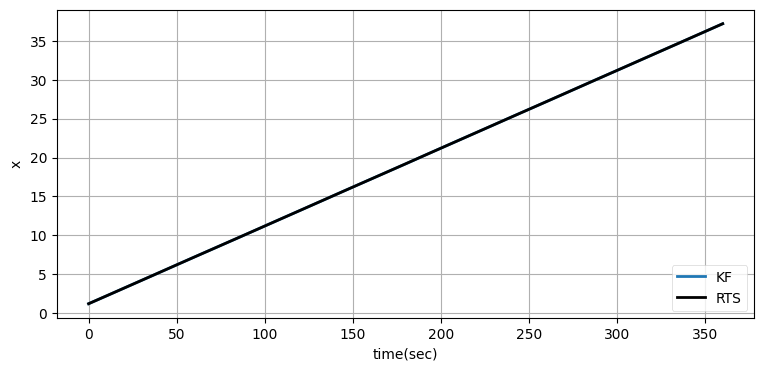

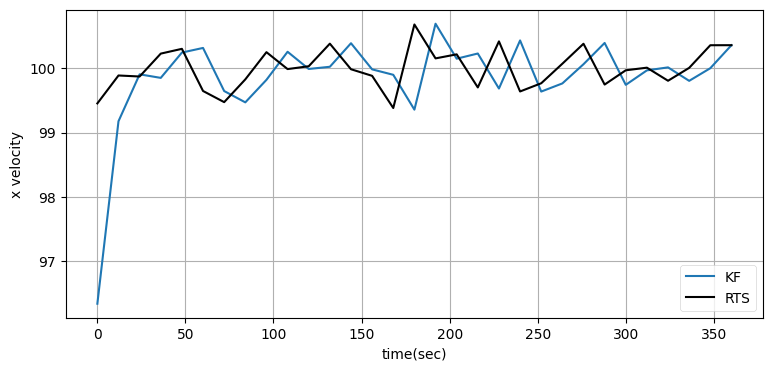

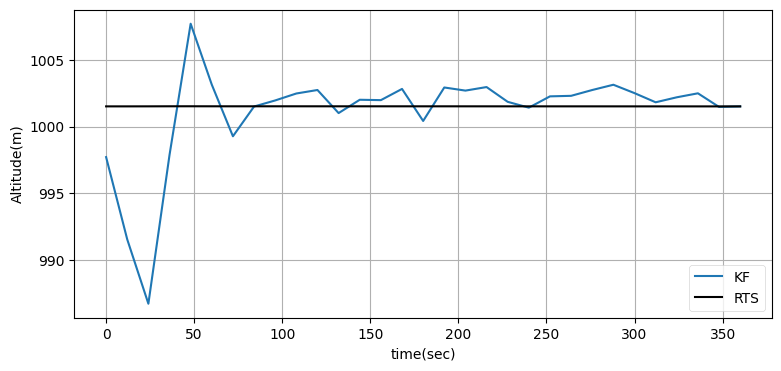

In [64]:
Ms, P, K = kf.rts_smoother(xs, covs)
ukf_internal.plot_rts_output(xs, Ms, t)

这些图表显示位置的改进很小，但速度的改进很好，高度的改进则非常显著。位置之间的差异非常小，因此我打印了UKF和平滑结果的最后5个点之间的差异。我建议如果你可以对数据进行后处理，那么总是使用RTS平滑器。

# 选择计算sigma点的参数

选择 $\alpha$、$\beta$ 和 $\kappa$ 的文献资料相对较少。Van der Merwe 的论文包含了最多的信息，但也不是穷尽全面的。所以让我们来探讨一下它们的作用。

Van der Merwe 建议对于高斯问题使用 $\beta=2$，以及 $\kappa=3-n$。所以我们从这里开始，变化 $\alpha$。我会让 $n=1$，以最小化我们需要查看的数组大小，并避免计算矩阵的平方根。

In [65]:
from kf_book.ukf_internal import print_sigmas
print_sigmas(mean=0, cov=3, alpha=1)

sigmas:  [ 0.  3. -3.]
mean weights: [0.6667 0.1667 0.1667]
cov weights: [2.6667 0.1667 0.1667]
lambda: 2
sum cov 2.9999999999999996


这里发生了什么？我们可以看到，对于均值为0，算法选择了sigma点0、3和-3，但为什么呢？回想一下计算sigma点的方程：

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

我选择的 $n=1$ 将所有内容都简化为标量，从而避免了计算矩阵的平方根。因此，对于我们的值，该方程为

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= \pm 3
\end{aligned}$$

所以随着 $\alpha$ 变大，sigma点会更加分散。让我们将其设为一个荒谬的值。

In [66]:
print_sigmas(mean=0, cov=3, alpha=200)

sigmas:  [   0.  600. -600.]
mean weights: [1. 0. 0.]
cov weights: [-39996.      0.      0.]
lambda: 119999
sum cov -39996.00000000001


我们可以看到，sigma点在100个标准差范围内分布。如果我们的数据是高斯分布，我们将会合并许多标准差外的数据；对于非线性问题，这不太可能产生良好的结果。但假设我们的分布不是高斯的，而是具有非常厚的尾部？我们可能需要从这些尾部进行采样来获得良好的估计，因此将 $\kappa$ 设置得更大可能是合理的（不是200，这个值太大，使得sigma点的变化非常明显）。

按照类似的推理，假设我们的分布几乎没有尾部——概率分布看起来更像一个倒置的抛物线。在这种情况下，我们可能希望将sigma点拉近到均值附近，以避免在永远不会有真实数据的区域进行采样。

现在让我们看一下权重的变化。当 $k+n=3$ 时，均值的权重为0.6667，两个较远的sigma点的权重为0.1667。另一方面，当 $\alpha=200$ 时，均值的权重飙升至0.99999，而异常值的权重则被设置为0.000004。回想一下权重的方程：

$$\begin{aligned}
W_0 &= \frac{\lambda}{n+\lambda} \\
W_i &= \frac{1}{2(n+\lambda)}
\end{aligned}$$

我们可以看到，随着 $\lambda$ 变大，均值权重的分数 ($\lambda/(n+\lambda)$) 接近1，其余sigma点的权重分数接近0。这与你的协方差的大小无关。所以，随着我们样本点离均值越来越远，我们给予这些样本的权重越来越少，如果我们在均值附近进行采样，我们会给予所有样本非常相似的权重。

然而，Van der Merwe 给出的建议是将 $\alpha$ 限制在 $0 \gt \alpha \ge 1$ 的范围内。他建议 $10^{-3}$ 是一个不错的值。让我们试试看。

In [67]:
print_sigmas(mean=0, cov=13, alpha=.001, kappa=0)

sigmas:  [ 0.      0.0036 -0.0036]
mean weights: [-999999.  500000.  500000.]
cov weights: [-999996.  500000.  500000.]
lambda: -0.999999
sum cov 3.9999989999923855


# 机器人定位 - 一个完整的示例

是时候着手解决一个重要问题了。大多数书籍选择简单的、有简单答案的教科书问题，让你不知道如何解决真实世界的问题。这个例子不会教你如何解决所有问题，但它阐明了你在设计和实施过滤器时需要考虑的事情。

我们将考虑机器人定位的问题。在这种情况下，我们有一个机器人通过传感器在景观中移动，用来探测地标。这可能是一辆使用计算机视觉识别树木、建筑物和其他地标的自动驾驶汽车。它可能是那种在家里吸尘的小型机器人，或者是仓库里的机器人。

这个机器人有4个轮子，布置方式与汽车相同。它通过转动前轮来操纵，这会使得机器人在向前移动时围绕后轮轴旋转。这是非线性行为，我们需要对其进行建模。

机器人有一个传感器，可以给出它与景观中已知目标的大致距离和方位角。这是非线性的，因为从距离和方位角计算位置需要使用平方根和三角函数。

过程模型和测量模型都是非线性的。UKF（无迹卡尔曼滤波）能够同时处理这两种非线性，因此我们初步得出结论，UKF是解决这个问题的可行选择。

# 机器人运动模型

在初步近似下，汽车在向前行驶时通过转动前轮来转向。汽车的前部沿着轮子指向的方向移动，同时围绕后轮旋转。然而，这种简单描述被诸如摩擦导致的打滑、橡胶轮胎在不同速度下的不同行为以及外侧轮胎需要走不同半径的轨迹等问题所复杂化了。精确建模转向需要一系列复杂的微分方程。

对于卡尔曼滤波，特别是在低速机器人应用中，人们发现了一个更简单的“自行车模型”能够表现良好。这是该模型的描述：

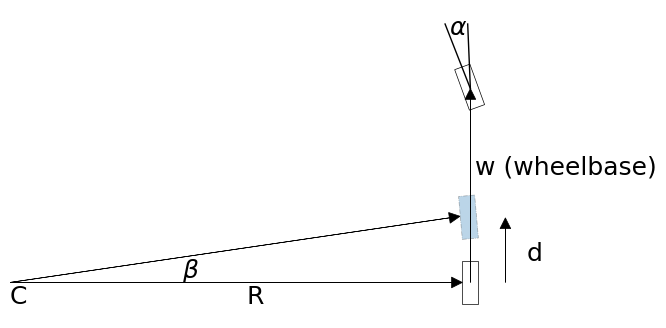

In [68]:
ekf_internal.plot_bicycle()

这里我们看到前轮相对于轴距指向角度$\alpha$。在短时间内，汽车向前移动，后轮最终会更进一步并稍微向内转动，就像蓝色阴影轮胎所示。在这么短的时间范围内，我们可以将其近似为围绕半径$R$转弯。我们可以用以下公式计算转弯角度$\beta$：

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

转弯半径$R$由以下公式给出：

$$R = \frac{d}{\beta}$$

其中，后轮在前进速度$v$下移动的距离为$d=v\Delta t$。

假设$\theta$是机器人的朝向，我们可以在转弯开始前计算出位置$C$：

$$\begin{aligned}
C_x &= x - R\sin(\theta) \\
C_y &= y + R\cos(\theta)
\end{aligned}$$

在向前移动时间$\Delta t$后，机器人的新位置和朝向是：

$$\begin{aligned} \bar x &= C_x + R\sin(\theta + \beta) \\
\bar y &= C_y - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

一旦我们代入$C$，我们得到：

$$\begin{aligned} \bar x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
\bar y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

如果你对转向模型不感兴趣，不需要深入了解这个数学内容。重要的是要认识到我们的运动模型是非线性的，我们需要在卡尔曼滤波中处理这一点。

# 设计状态变量

对于我们的机器人，我们将保持位置和方向：

$$\mathbf x = \begin{bmatrix}x & y & \theta\end{bmatrix}^\mathsf{T}$$

我本可以将速度包含在这个模型中，但正如你将看到的，数学已经相当具有挑战性了。

控制输入$\mathbf{u}$是指令速度和转向角度：

$$\mathbf{u} = \begin{bmatrix}v & \alpha\end{bmatrix}^\mathsf{T}$$

# 设计系统模型

我们将我们的系统建模为非线性运动模型加上白噪声。

$$\bar x = x + f(x, u) + \mathcal{N}(0, Q)$$

利用我们之前创建的机器人运动模型，我们可以写成：

In [69]:
from math import tan, sin, cos, sqrt

def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb, 
                              r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

我们将使用这个函数来实现状态转移函数 `f(x)`。

我将设计UKF使得$\Delta t$很小。如果机器人移动缓慢，那么这个函数应该能够给出相当精确的预测。如果$\Delta t$很大或者你的系统动态非常非线性，这种方法就会失败。在那些情况下，你将需要使用更复杂的数值积分技术，比如Runge Kutta。数值积分在**卡尔曼滤波数学**章节中有简要介绍。

# 设计测量模型

传感器提供了对景观中多个已知位置的带有噪声的方位角和距离。测量模型必须将状态$\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$转换为地标的距离和方位角。如果$p$是地标的位置，那么距离$r$为：

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

我们假设传感器提供的方位角是相对于机器人朝向的，因此我们必须从方位角中减去机器人的朝向以得到传感器读数，如下所示：

$$\phi = \tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$$

因此，我们的测量函数是：

$$\begin{aligned}
\mathbf{z}& = h(\mathbf x, \mathbf P) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

我暂时不会实现这个，因为在下面的*实现*部分中有一个需要讨论的困难。

# 设计测量噪声

合理假设距离和方位角的测量噪声是独立的，因此

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

# 实现

在开始编码之前，我们还有另一个问题要处理。残差是$y = z - h(x)$。假设$z$的方位角是$1^\circ$，而$h(x)$是$359^\circ$。两者相减得到$-358^\circ$。这将影响卡尔曼增益的计算，因为正确的角度差是$2^\circ$。因此，我们需要编写代码来正确计算方位角的残差。

In [70]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [71]:
print(np.degrees(normalize_angle(np.radians(1-359))))

1.9999999999999774


状态向量中的方位角在索引2处，但测量向量中在索引1处，所以我们需要编写处理每个的函数。我们还面临另一个问题，随着机器人的操纵，不同的地标将会可见，因此我们需要处理可变数量的测量。测量中的残差函数将接收到一个包含多个测量的数组，每个测量对应一个地标。

In [75]:
def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

我们现在可以实现测量模型。方程是
$$h(\mathbf x, \mathbf P)
= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix}$$

表达式$\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$可能会得到超出范围$[-\pi, \pi)$的结果，因此我们应该将角度归一化到该范围内。

该函数将接收到一个地标的数组，并需要生成一个形式为`[距离_1, 方位角_1, 距离_2, 方位角_2, ...]`的测量数组。

In [76]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

我们的困难还没有结束。无迹变换计算状态和测量向量的平均值，但每个向量都包含一个方位角。计算一组角度的平均值没有唯一的方法。例如，359$^\circ$和3$^\circ$的平均值是多少？直觉告诉我们答案应该是1$^\circ$，但一个简单的$\frac{1}{n}\sum x$方法会得到181$^\circ$。

一个常见的方法是对正弦和余弦的和取反正切。

$$\bar{\theta} = atan2\left(\frac{\sum_{i=1}^n \sin\theta_i}{n}, \frac{\sum_{i=1}^n \cos\theta_i}{n}\right)$$

`UnscentedKalmanFilter.__init__()`有一个参数`x_mean_fn`用于计算状态的平均值的函数，`z_mean_fn`用于计算测量的平均值的函数。我们将编写这些函数：

In [77]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = atan2(sum_sin, sum_cos)
    return x

这些函数利用了NumPy的三角函数可以对数组进行操作，并且`dot`执行元素级的乘法。NumPy是用C和Fortran实现的，所以`sum(dot(sin(x), w))`比在Python中编写等效循环要快得多。

有了这些，我们现在准备实现无迹卡尔曼滤波器（UKF）。我想指出的是，当我设计这个滤波器时，并不是一次性从头开始设计上面所有的函数。我先组建了一个带有预定义地标的基本UKF，验证它是否可行，然后开始填充细节部分。"如果我看到不同的地标怎么办？"这让我修改了测量函数，让它能接受一个地标数组。"如何计算角度的*均值*？"这促使我编写了角度归一化代码。"一组角度的*均值*是什么？"我在互联网上搜索，找到了维基百科上的一篇文章，然后实现了那个算法。不要感到畏缩。先设计你能做的，然后提出问题并逐个解决。

你已经看到了UKF的实现，所以我不会详细描述它。这里有两个新的内容。当我们构建sigma点和滤波器时，我们必须提供我们编写的函数来计算残差和均值。

```python
points = SigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                     subtract=residual_x)

ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=Hx, dt=dt, points=points,
         x_mean_fn=state_mean, z_mean_fn=z_mean,
         residual_x=residual_x, residual_z=residual_h)
```

接下来，我们需要将额外的数据传递给我们的`f(x, dt)`和`h(x)`函数。我们想要在`f(x, dt)`中使用`move(x, dt, u, wheelbase)`，在`h(x)`中使用`Hx(x, landmarks)`。我们可以做到这一点，只需要像这样将额外的参数作为关键字参数传递给`predict()`和`update()`：

```python
            ukf.predict(u=u, wheelbase=wheelbase)        
            ukf.update(z, landmarks=landmarks)
```

代码的其余部分运行了模拟并绘制了结果。我创建了一个变量`landmarks`，其中包含了地标的坐标。我每秒更新模拟机器人的位置10次，但每秒只运行一次UKF。我们没有使用Runge Kutta来积分运动的微分方程，所以小的时间步长可以使模拟更准确。

In [78]:
from filterpy.stats import plot_covariance_ellipse

dt = 1.0
wheelbase = 0.5

def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, ellipse_step=1, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UKF(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='k', alpha=0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

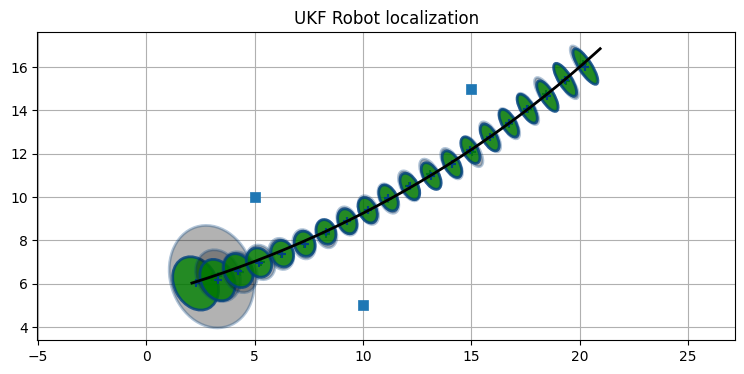

Final P: [0.0092 0.0187 0.0007]


In [79]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())

代码的其余部分运行了模拟并绘制了结果。我创建了一个名为`landmarks`的变量，其中包含了地标的坐标。我每秒更新模拟机器人的位置10次，但只运行UKF一次。这样做有两个原因。首先，我们没有使用Runge Kutta来积分运动的微分方程，因此较窄的时间步长可以使我们的模拟更准确。其次，在嵌入式系统中有限的处理速度是相当正常的。这迫使你只在绝对必要时才以所需频率运行卡尔曼滤波器。

# 操纵机器人

上述运行中的转向模拟并不现实。速度和转向角从未改变，这对卡尔曼滤波器并不构成太大问题。我们可以实现一个复杂的PID控制机器人模拟，但我将仅使用NumPy的`linspace`方法生成不同的转向命令。我还会添加更多的地标，因为机器人将行驶的距离比第一个示例要远得多。

In [80]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
  return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)

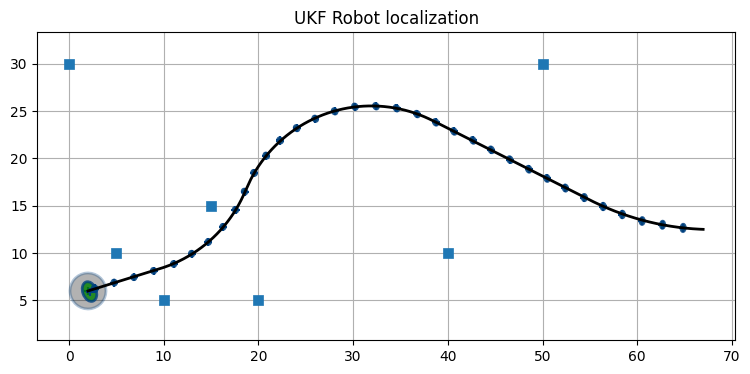

final covariance [0.0013 0.0043 0.0004]


In [81]:
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

不确定性迅速变得非常小。协方差椭圆显示的是$6\sigma$的协方差，但椭圆太小了，很难看清。我们可以通过仅提供附近两个地标的方式增加一些误差到结果中。当我们运行这个滤波器时，随着机器人离这些地标越来越远，误差也会增加。

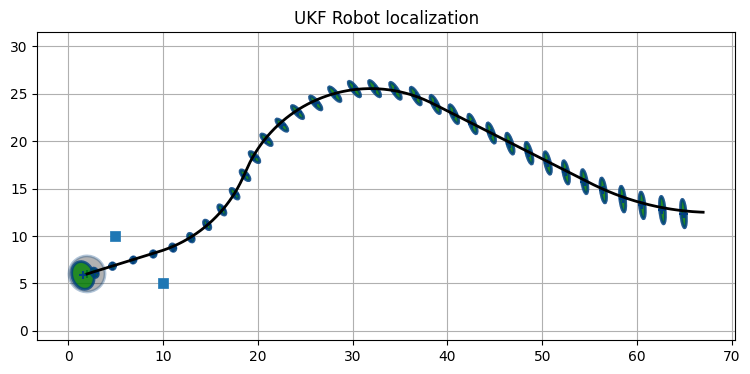

final covariance [0.0026 0.0657 0.0008]


In [82]:
ukf = run_localization(
    cmds, landmarks[0:2], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

# 讨论

这一章给你的印象可能取决于你以往实现过多少非线性卡尔曼滤波器。如果这是你第一次接触，也许计算$2n+1$个sigma点并随后编写$f(x)$和$h(x)$函数让你感觉有些繁琐。事实上，因为需要处理角度的模运算，我花了比我想承认的更多时间来让所有东西都能正常工作。另一方面，如果你已经实现过扩展卡尔曼滤波器（EKF），也许你会欢欣鼓舞。编写UKF的函数有些单调乏味，但概念非常基础。对于同样的问题，EKF需要一些相当困难的数学。对于许多问题，我们无法找到EKF方程的闭式解，必须退而求其次采用某种迭代解决方案。

UKF相对于EKF的优势不仅仅是相对容易的实现。现在讨论这点有些为时过早，因为你还没有学习EKF，但是EKF在线性化问题时在一个点上，并将该点通过线性卡尔曼滤波器。相反，UKF采用$2n+1$个样本。因此，UKF通常比EKF更准确，特别是当问题高度非线性时。虽然并非总是如此，UKF能始终优于EKF，但在实践中已经证明其至少与EKF一样表现良好，通常比EKF好得多。

因此，我的建议是始终从实现UKF开始。如果你的滤波器发散会有现实世界的后果（人员死亡、大量金钱损失、发电厂爆炸），当然你必须进行复杂的分析和实验来选择最佳的滤波器。这已超出了本书的范围，你应该去研究生院学习这个理论。

最后，我将UKF称为*执行sigma点滤波器的方法*。这并不完全正确。我选择的具体版本是Julier的缩放非线性滤波器，由Van der Merwe在他2004年的论文中参数化。如果你搜索Julier、Van der Merwe、Uhlmann和Wan，你会发现他们开发的一系列类似的sigma点滤波器。每种技术都使用不同的方式选择和加权sigma点。但选择不止于此。例如，SVD卡尔曼滤波器使用奇异值分解（SVD）来找到概率分布的近似均值和协方差。把这一章看作是sigma点滤波器的介绍，而不是对它们工作原理的最终阐述。

# 参考

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [3] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [4] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [5] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition